### Importing the libraries:

In [6]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00


In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import InputLayer, Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle
import plotly.express as px

from numpy import mean
from numpy import std
from numpy import dstack
from keras.utils import to_categorical

import itertools

 chenge this function to convert sequences which has 3 feature input and categorical_class as output


### function to create sequences:

In [8]:
def to_sequences(df, seq_size=128, seq_stride=128, feature='CURRENT|6', y_type='wear_class', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    x2_values = []
    x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df['CURRENT|6']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])

    for index, data in enumerate(df['CURRENT|1']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x2_values.append(data[i:(i+seq_size)])

    for index, data in enumerate(df['CURRENT|2']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x3_values.append(data[i:(i+seq_size)])

    
    if mix=='ON':
      x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly = shuffle(x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        'CURRENT|6':x1_values,
        'CURRENT|1':x2_values,
        'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values, x2_values, x3_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

In [9]:
def to_sequences_1_feature(df, seq_size=128, seq_stride=128, y_type='wear_class', feature='CURRENT|6', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    #x2_values = []
    #x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df[feature]):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])
    
    if mix=='ON':
      x1_values, file_index, wear_class, is_anomaly = shuffle(x1_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        feature:x1_values,
        #'CURRENT|1':x2_values,
        #'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

### function to plot loss and accuracy

In [10]:
def plot_loss(history):
  plt.plot(history['loss'], label='Training loss');
  plt.plot(history['val_loss'], label='Validation loss');
  plt.xlabel("Epoch")
  plt.ylabel("loss")
  plt.legend()
  return

In [11]:
def plot_accuracy(history):
  plt.plot(history['accuracy'], label='Accuracy');
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel("Epoch")
  plt.ylabel("accuracy")
  plt.legend()
  return

### 1d CNN model:

In [25]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

#balanced_df = balanced_df[balanced_df.file_no.isin([5,6,7,8])] #1,2,3,4,9,10,11,12

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()

balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
window_size = 300
df_seq, X, y = to_sequences(balanced_df_list, window_size, window_size, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
#print_anomaly_stats(df_seq, cur_val_col='CURRENT|6');
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count()) 

train_test_split = 0.8  # 80% test train split ratio
to_split_at = int(train_test_split*X.shape[0])
df_seq_train, X_train1, y_train1 = df_seq[:to_split_at], X[:to_split_at], y[:to_split_at]
print(X_train1.shape, y_train1.shape)
df_seq_test, X_test1, y_test1 = df_seq[to_split_at:], X[to_split_at:], y[to_split_at:]
print(X_test1.shape, y_test1.shape)
print('------')
df = df_seq_train.reset_index()
print('total_train_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')
df = df_seq_test.reset_index()
print('total_test_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())

trainX, trainy, testX, testy = X_train1, y_train1, X_test1, y_test1
verbose, epochs, batch_size = 1, 70, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model_1 = Sequential()
model_1.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_1.add(MaxPooling1D())
model_1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Flatten())
#model_1.add(LSTM(64))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(n_outputs, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()
# fit network
model_1_history = model_1.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=verbose).history #
# evaluate model
_, accuracy = model_1.evaluate(testX, testy, batch_size=batch_size, verbose=1)

(2577, 300, 3) (2577, 2)
----
total_sequences:  2577
wear_class
0    1287
1     248
2     521
3     521
Name: wear_class, dtype: int64
(2061, 300, 3) (2061, 2)
(516, 300, 3) (516, 2)
------
total_train_sequences:  2061
wear_class
0    1042
1     197
2     419
3     403
Name: wear_class, dtype: int64
------
total_test_sequences:  516
wear_class
0    245
1     51
2    102
3    118
Name: wear_class, dtype: int64
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 296, 64)           1024      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 148, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 146, 64)           12352     
                                     

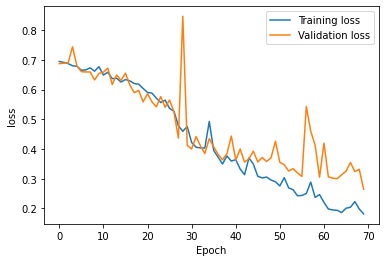

In [26]:
plot_loss(model_1_history)

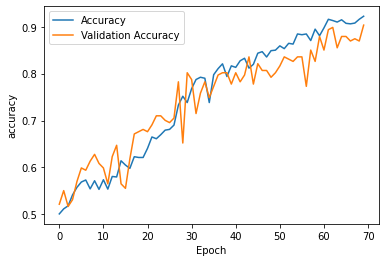

In [27]:
plot_accuracy(model_1_history)

### Confusion matrix: Train

65/65 [==============================] - 1s 8ms/step
[[1020   22]
 [ 106  913]]
              precision    recall  f1-score   support

       False       0.91      0.98      0.94      1042
        True       0.98      0.90      0.93      1019

    accuracy                           0.94      2061
   macro avg       0.94      0.94      0.94      2061
weighted avg       0.94      0.94      0.94      2061



<ipython-input-28-1cca43f4b99a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)


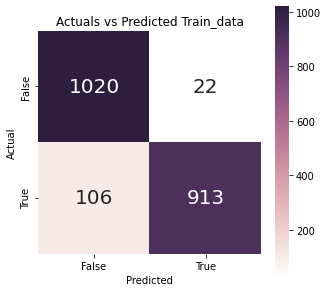

In [28]:
trainPredict1 = model_1.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

### Confusion matrix: Test

17/17 [==============================] - 0s 8ms/step
[[224  21]
 [ 45 226]]
              precision    recall  f1-score   support

       False       0.83      0.91      0.87       245
        True       0.91      0.83      0.87       271

    accuracy                           0.87       516
   macro avg       0.87      0.87      0.87       516
weighted avg       0.88      0.87      0.87       516



<ipython-input-29-396dbc7bf8e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)


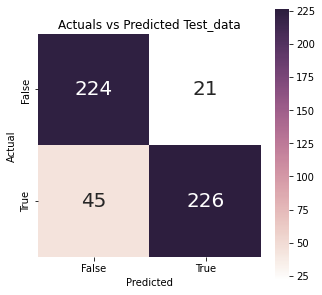

In [29]:
testPredict1 = model_1.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

## LSTM model:

In [51]:
verbose, epochs, batch_size = 1, 10, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model_2 = Sequential()
model_2.add(LSTM(128, activation='tanh', input_shape=(n_timesteps,n_features), return_sequences=True))
model_2.add(LSTM(128, activation='tanh', return_sequences=False))
#model_2.add(LSTM(64, activation='tanh', return_sequences=False))
model_2.add(Dense(n_outputs, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()
# fit network
model_2_history = model_2.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=verbose).history #
# evaluate model
_, accuracy = model_2.evaluate(testX, testy, batch_size=batch_size, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 300, 128)          67584     
                                                                 
 lstm_12 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 2)                 258       
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
58/58 [==============================] - 64s 1s/step - loss: 0.6959 - accuracy: 0.4995 - val_loss: 0.6969 - val_accuracy: 0.4444
Epoch 2/10
58/58 [==============================] - 73s 1s/step - loss: 0.6940 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5169
Epoch 3/10
58/58 [==============

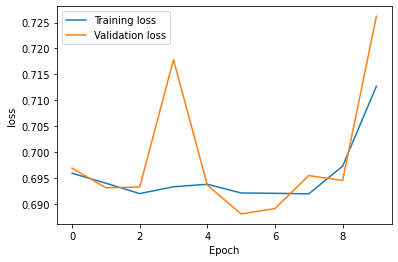

In [52]:
plot_loss(model_2_history)

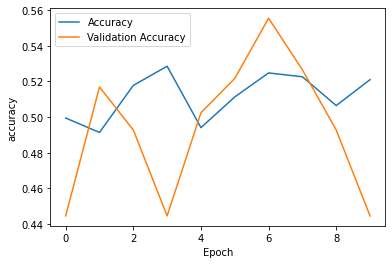

In [53]:
plot_accuracy(model_2_history)

### Confusion matrix: Train

65/65 [==============================] - 24s 356ms/step


<ipython-input-54-856be2847616>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

[[   0 1042]
 [   0 1019]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1042
        True       0.49      1.00      0.66      1019

    accuracy                           0.49      2061
   macro avg       0.25      0.50      0.33      2061
weighted avg       0.24      0.49      0.33      2061



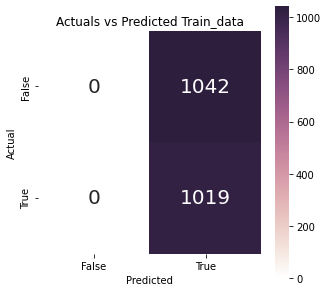

In [54]:
trainPredict1 = model_2.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

### Confusion matrix: Test

17/17 [==============================] - 4s 259ms/step
[[  0 245]
 [  0 271]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       245
        True       0.53      1.00      0.69       271

    accuracy                           0.53       516
   macro avg       0.26      0.50      0.34       516
weighted avg       0.28      0.53      0.36       516



<ipython-input-55-4044afeaa91f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

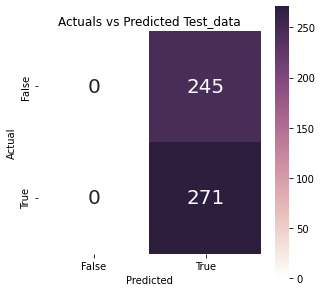

In [55]:
testPredict1 = model_2.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

## 1dCNN+LSTM:

In [62]:
verbose, epochs, batch_size = 1, 70, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model_3 = Sequential()
model_3.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_3.add(MaxPooling1D())
model_3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model_3.add(Dropout(0.2))
model_3.add(MaxPooling1D())
#model_3.add(Flatten()) #adding this does not support the dimension to next LSTM layer
model_3.add(LSTM(64))
model_3.add(Dense(n_outputs, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()
# fit network
model_3_history = model_3.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=verbose).history #
# evaluate model
_, accuracy = model_3.evaluate(testX, testy, batch_size=batch_size, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 296, 64)           1024      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 148, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 146, 64)           12352     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 73, 64)           0         
 g1D)                                                            
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 2)               

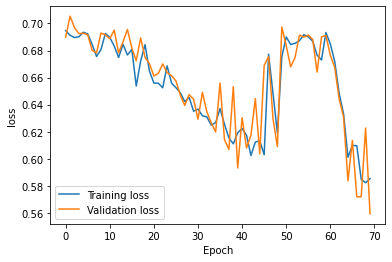

In [63]:
plot_loss(model_3_history)

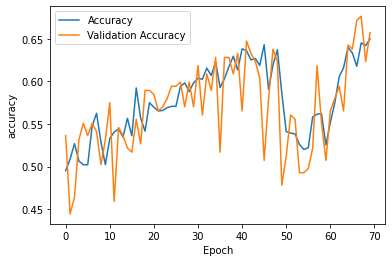

In [64]:
plot_accuracy(model_3_history)

### Confusion matrix: Train

65/65 [==============================] - 2s 20ms/step
[[811 231]
 [476 543]]
              precision    recall  f1-score   support

       False       0.63      0.78      0.70      1042
        True       0.70      0.53      0.61      1019

    accuracy                           0.66      2061
   macro avg       0.67      0.66      0.65      2061
weighted avg       0.67      0.66      0.65      2061



<ipython-input-65-c6ad53c404ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)


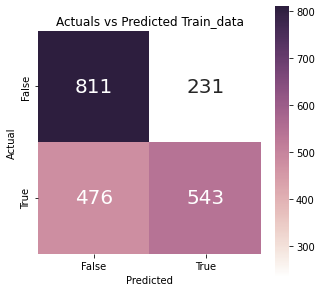

In [65]:
trainPredict1 = model_3.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

### Confusion matrix: Test

17/17 [==============================] - 0s 19ms/step


<ipython-input-66-10800813e542>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)


[[176  69]
 [136 135]]
              precision    recall  f1-score   support

       False       0.56      0.72      0.63       245
        True       0.66      0.50      0.57       271

    accuracy                           0.60       516
   macro avg       0.61      0.61      0.60       516
weighted avg       0.62      0.60      0.60       516



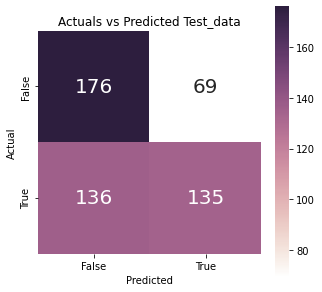

In [66]:
testPredict1 = model_3.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

## See Result on LSTM_AE:

In [ ]:
save_dir = '/content/drive/MyDrive/saved_model/'
this_model_name = 'final_LSTM_AE' #100_10_f5678_minMaxScl_1c_1l_3x_2y_tlwr_v1
lstm_autoencoder = tf.keras.models.load_model(save_dir+this_model_name)

df_seq_test, X_test1, y_test1

Predict = lstm_autoencoder.predict(X_test1)
MAE = np.mean(np.abs(Predict - X_test1), axis=1);
plt.hist(MAE, bins=50);

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.03, 0.04]
[[ 83 162]
 [ 81 190]]
              precision    recall  f1-score   support

       False       0.51      0.34      0.41       245
        True       0.54      0.70      0.61       271

    accuracy                           0.53       516
   macro avg       0.52      0.52      0.51       516
weighted avg       0.52      0.53      0.51       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

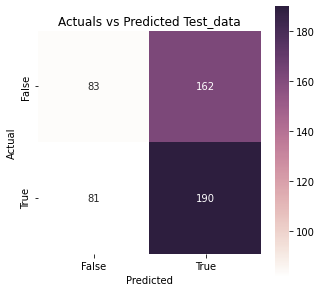

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.03, 0.05]
[[ 84 161]
 [ 85 186]]
              precision    recall  f1-score   support

       False       0.50      0.34      0.41       245
        True       0.54      0.69      0.60       271

    accuracy                           0.52       516
   macro avg       0.52      0.51      0.50       516
weighted avg       0.52      0.52      0.51       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

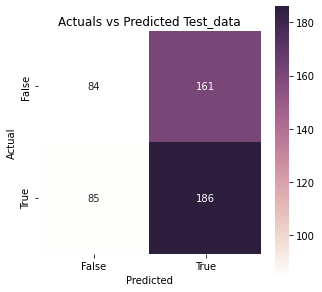

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.04, 0.04]
[[101 144]
 [111 160]]
              precision    recall  f1-score   support

       False       0.48      0.41      0.44       245
        True       0.53      0.59      0.56       271

    accuracy                           0.51       516
   macro avg       0.50      0.50      0.50       516
weighted avg       0.50      0.51      0.50       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

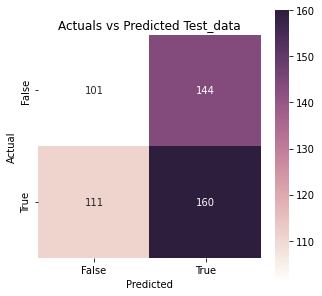

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.04, 0.05]
[[103 142]
 [115 156]]
              precision    recall  f1-score   support

       False       0.47      0.42      0.44       245
        True       0.52      0.58      0.55       271

    accuracy                           0.50       516
   macro avg       0.50      0.50      0.50       516
weighted avg       0.50      0.50      0.50       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

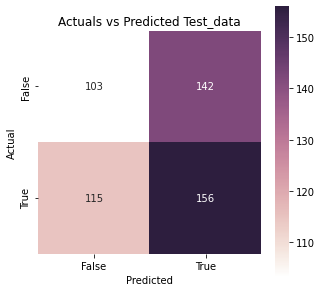

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.05, 0.04]
[[112 133]
 [129 142]]
              precision    recall  f1-score   support

       False       0.46      0.46      0.46       245
        True       0.52      0.52      0.52       271

    accuracy                           0.49       516
   macro avg       0.49      0.49      0.49       516
weighted avg       0.49      0.49      0.49       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

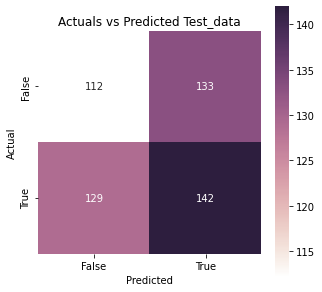

[threshold_1, threshold_2, threshold_3]:  [0.05, 0.05, 0.05]
[[115 130]
 [134 137]]
              precision    recall  f1-score   support

       False       0.46      0.47      0.47       245
        True       0.51      0.51      0.51       271

    accuracy                           0.49       516
   macro avg       0.49      0.49      0.49       516
weighted avg       0.49      0.49      0.49       516



<ipython-input-50-97af6ae58037>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-50-97af6ae58037>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

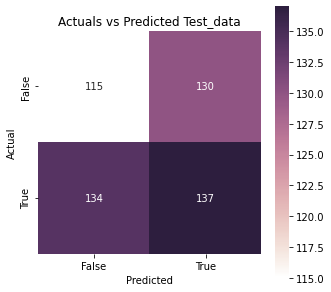

In [50]:
max_trainMAE_1 = 0.05
max_trainMAE_2 = 0.04
max_trainMAE_3 = 0.04

df_result, original, MAE, reconstructed = df_seq_test, X_test1, MAE, Predict
range_trainMAE = [[0.05],[0.03,0.04,0.05],[0.04,0.05]]
for l in itertools.product(*range_trainMAE):
  [threshold_1, threshold_2, threshold_3] = l 
  print("[threshold_1, threshold_2, threshold_3]: ",[threshold_1, threshold_2, threshold_3])
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
  df_result[['MAE_1', 'MAE_2', 'MAE_3']] = MAE #MAE
  # [x for x in np.repeat(threshold,df_result.shape[0],axis=0)]
  df_result['threshold_1'] = threshold_1 
  df_result['threshold_2'] = threshold_2
  df_result['threshold_3'] = threshold_3
  df_result['pred_anomaly'] = (df_result['MAE_1'] > df_result['threshold_1']) | (df_result['MAE_2'] > df_result['threshold_2']) | (df_result['MAE_3'] > df_result['threshold_3'])
  df_result['anomaly_or_not'] = df_result['anomaly_or_not'].astype('bool')

  from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
  org = df_result.anomaly_or_not #df_seq_train.wear_class
  pred = df_result.pred_anomaly
  data = confusion_matrix(org,pred)
  print(data)
  print(classification_report(org, pred))
  df_cm = pd.DataFrame(data, columns= np.unique(org), index = np.unique(org)) # columns= np.unique(org)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  f, ax = plt.subplots(figsize=(5, 5))
  cmap = sns.cubehelix_palette(light=1, as_cmap=True)
  sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f', annot_kws={'size': 20});
  plt.title('Actuals vs Predicted Test_data')
  plt.show()